In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Set up openjdk paths for spark

# for MacOS
import os
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/openjdk-17.jdk/Contents/Home'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

In [78]:
# Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from cider.schemas import (
    CallDataRecordData,
    AntennaData,
    MobileMoneyTransactionData,
)
from cider.utils import generate_all_synthetic_data, validate_dataframe, generate_synthetic_shapefile
from cider.homelocation.schemas import GeographicUnit, GetHomeLocationAlgorithm
from cider.homelocation.core import get_home_locations
from cider.homelocation.plotting import make_location_map

from cider.featurizer.core import preprocess_data, featurize_all_data
from cider.featurizer.dependencies import get_static_diagnostic_statistics, get_timeseries_diagnostic_statistics
from cider.featurizer.plotting import plot_timeseries_diagnostics

from cider.validation_metrics.core import (
    compute_auc_roc_precision_recall_with_percentile_grid, 
    compute_utility_grid, 
    calculate_optimal_utility_and_cash_transfer_size_table,
    calculate_rank_residuals_by_characteristic,
    combine_tables_on_characteristic,)
from cider.validation_metrics.plotting import (
    plot_roc_precision_recall_curves,
    plot_utility_values,
    plot_rank_residual_distributions_per_characteristic_value,
    plot_all_fairness_metrics_per_characteristic_value)

# Step 1: Get data

In [79]:
# Set vars
num_data_points = 2000
num_unique_antenna_ids = 100
num_regions = 10
random_seed = 42

# Generate synthetic data OR load your own data here
synthetic_data = generate_all_synthetic_data(
    num_data_points=num_data_points,
    num_unique_antenna_ids=num_unique_antenna_ids,
    random_seed=random_seed,
)


shapefile_gdf = generate_synthetic_shapefile(
    antenna_df=synthetic_data[AntennaData],
    num_regions=num_regions,
    random_seed=random_seed,
)

# Validate data
for data_schema, data_df in synthetic_data.items():
    validate_dataframe(data_df, data_schema)

/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/utils.py:174: Warning: Generating synthetic data for CallDataRecordData schema may result in unrealistic duration values and incompatible antenna values.Use the `correct_generated_synthetic_cdr_data` function to correct these values after generation.
  warnings.warn(
/Users/poornimaramesh/Documents/IDinsight/GiveDirectly_x_Safaricom/cider/src/cider/utils.py:181: Warning: Generating synthetic data for MobileMoneyTransactionData schema may result in unrealistic amount values.Use the `correct_generated_synthetic_mobile_money_transaction_data` function to correct these values after generation.
  warnings.warn(


# Step 2: Infer transactions around home antenna


In [ ]:
geographic_unit = GeographicUnit.SHAPEFILE
algorithm = GetHomeLocationAlgorithm.COUNT_DAYS

homes_df = get_home_locations(
    cdr_data=synthetic_data[CallDataRecordData],
    antenna_data=synthetic_data[AntennaData],
    shapefile_data=shapefile_gdf,
    geographic_unit=geographic_unit,
    algorithm=algorithm,
    additional_columns_to_keep=[],
)

# Merge home locations with antenna data for plotting
homes_with_antenna_df = homes_df.merge(
    synthetic_data[AntennaData],
    left_on="caller_antenna_id",
    right_on="antenna_id",
    how="left")

homes_with_antenna_gdf = gpd.GeoDataFrame(
    homes_with_antenna_df,
    geometry=gpd.points_from_xy(
        x=homes_with_antenna_df['longitude'],
        y=homes_with_antenna_df['latitude'])
).set_crs(epsg=4326)

make_location_map(
    inferred_home_locations=homes_with_antenna_gdf,
    boundaries_shapefile=shapefile_gdf,
    column_to_plot_label="caller_antenna_id",
    column_to_plot_markersize=algorithm.value,
)

# Step 3: Preprocess data

In [ ]:
filter_start_date = datetime.strptime("2022-01-05", "%Y-%m-%d")
filter_end_date = datetime.strptime("2025-01-25", "%Y-%m-%d")
spammer_threshold = 1.75
outlier_day_z_score_threshold = 2.0

preprocessed_data = preprocess_data(
    data_dict=synthetic_data,
    filter_start_date=filter_start_date,
    filter_end_date=filter_end_date,
    spammer_threshold=spammer_threshold,
    outlier_day_z_score_threshold=outlier_day_z_score_threshold,
)


# Get diagnostics for preprocessed data
static_diagnostics = {}
timeseries_diagnostics = {}
for data_schema, data_df in preprocessed_data.items():
    static_diagnostics[data_schema] = get_static_diagnostic_statistics(data_df)
    print(static_diagnostics[data_schema])

    timeseries_diagnostics[data_schema] = get_timeseries_diagnostic_statistics(data_df)
    print(timeseries_diagnostics[data_schema].columns)
    fig = plot_timeseries_diagnostics(
        timeseries_diagnostics[data_schema],
        value_column="num_unique_callers",
        groupby_column="transaction_type" if data_schema in [CallDataRecordData, MobileMoneyTransactionData] else None,
        plot_title=f"Timeseries Diagnostics for {data_schema.__name__}",
    )
    plt.show()
    


# Step 4: Featurize data

In [ ]:
max_wait_for_convo_in_seconds = 3600
pareto_threshold = 0.8

# Prepare antenna_data
antenna_gdf = gpd.GeoDataFrame(
    synthetic_data[AntennaData],
    geometry=gpd.points_from_xy(
        x=synthetic_data[AntennaData]['longitude'],
        y=synthetic_data[AntennaData]['latitude'])
).set_crs(epsg=4326)
antennas_merged_shp = gpd.sjoin(antenna_gdf, shapefile_gdf, how='left', predicate='within')[['antenna_id', 'region']]
antennas_merged_shp.region.fillna('Unknown', inplace=True)
antennas_df = antennas_merged_shp.merge(
    synthetic_data[AntennaData],
    on="antenna_id")

preprocessed_data[AntennaData] = antennas_df

features_df = featurize_all_data(
    preprocessed_data=preprocessed_data,
    max_wait_for_convo_in_seconds=max_wait_for_convo_in_seconds,
    pareto_threshold=pareto_threshold,
)


# Step 6: Fit models

In [69]:
# Prepare features_df for modeling or analysis
features_df_clean = features_df.dropna(axis=1, how='any')

# Make fake groundtruth consumption values
groundtruth_consumption = np.random.rand(len(features_df_clean)) * 10
weights = np.random.randint(10, 100, size=len(features_df_clean))

# Train-test split
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(features_df_clean, groundtruth_consumption, weights, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train.drop(columns="caller_id"), y_train)

# Get predictions
y_pred_train = model.predict(X_train.drop(columns="caller_id"))
y_pred_test = model.predict(X_test.drop(columns="caller_id"))

# Prepare data
consumption_data = pd.DataFrame({
    'household_id': X_test['caller_id'],
    'groundtruth_consumption': y_test,
    'weight': weights_test,
    'proxy_consumption': y_pred_test,
})



# Step 7: Evaluate model predictions

In [70]:
fixed_groundtruth_percentile = 20  # Bottom 20% are considered "poor"

# Simulate additional characteristics for fairness analysis
np.random.seed(42)
allowed_gender_values = {'male', 'female', 'other'}
consumption_data_w_gender = consumption_data.copy()
consumption_data_w_gender['characteristic'] = np.random.choice(list(allowed_gender_values), size=len(consumption_data_w_gender))

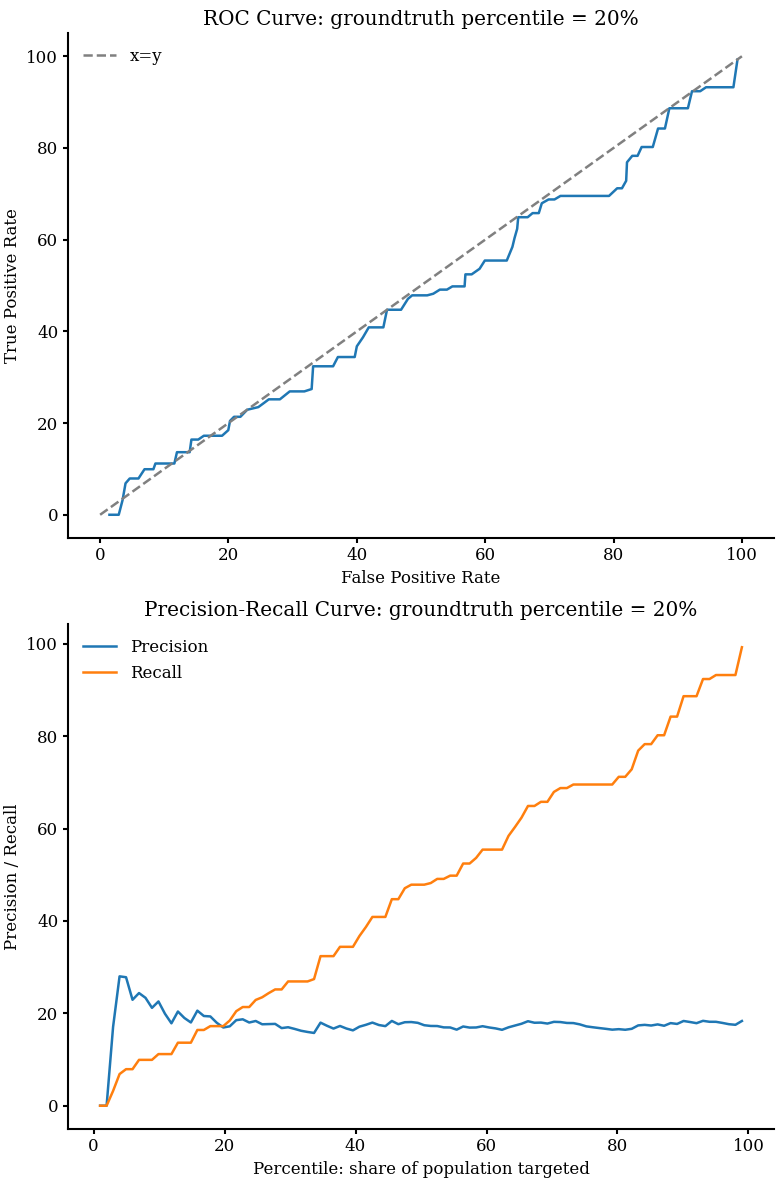

In [71]:

# AUC ROC
auc_roc_precision_recall_df = compute_auc_roc_precision_recall_with_percentile_grid(
    consumption_data,
    fixed_groundtruth_percentile,
    100)

# Plot ROC Curve
fig, ax = plot_roc_precision_recall_curves(auc_roc_precision_recall_df, fixed_groundtruth_percentile)
fig  

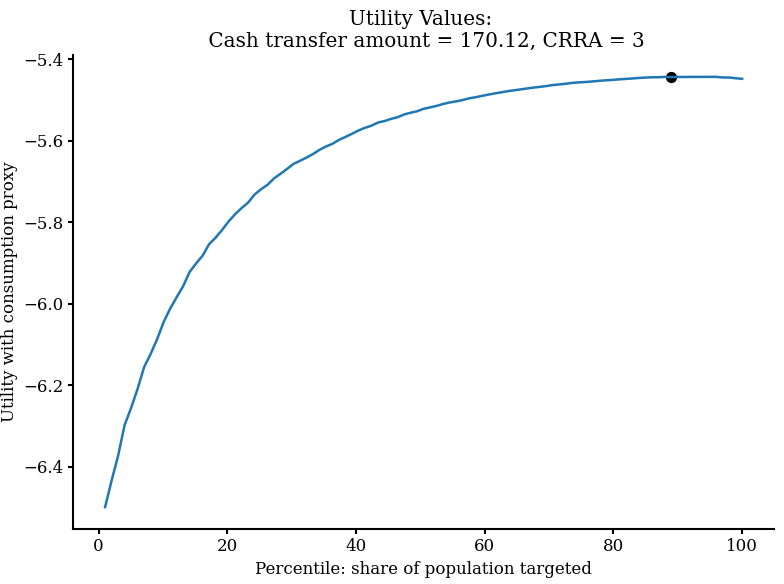

In [72]:
# Compute utility grid
cash_transfer_at_ubi_rate = 0.01 * consumption_data['weight'].sum()
utility_grid_df = compute_utility_grid(
    consumption_data,
    cash_transfer_amount=cash_transfer_at_ubi_rate,
    num_grid_points=99,
    constant_relative_risk_aversion=3.0)


optimal_utility_df = calculate_optimal_utility_and_cash_transfer_size_table(
    consumption_data,
    cash_transfer_amount=cash_transfer_at_ubi_rate,
    num_grid_points=10,
    constant_relative_risk_aversion=3.0
)

fig, ax = plot_utility_values(
    utility_grid_df, 
    optimal_utility_df.loc["proxy_consumption", "optimal_population_percentile"],
    optimal_utility_df.loc["proxy_consumption", "maximum_utility"],
    cash_transfer_at_ubi_rate, 3)
fig

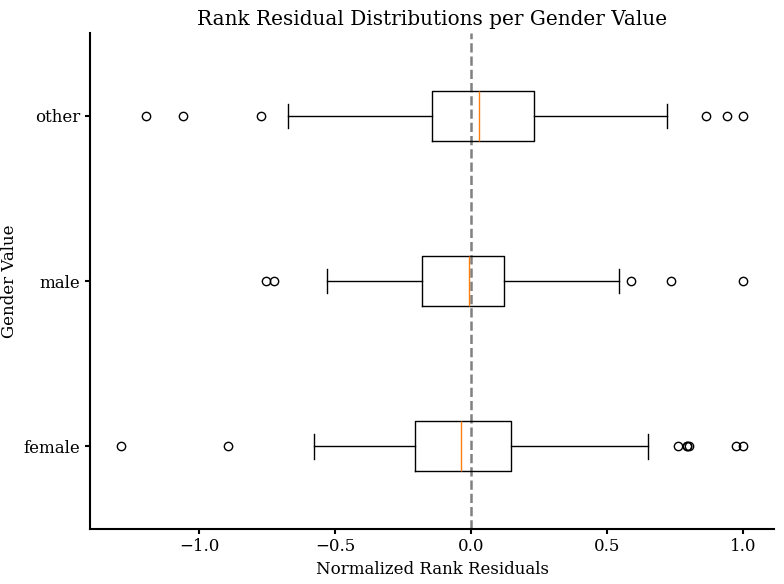

In [74]:
# Rank residuals per characteristic

rank_residual_df = calculate_rank_residuals_by_characteristic(
    consumption_data_w_gender)

# Plot rank residual distributions per characteristic value
fig, ax = plot_rank_residual_distributions_per_characteristic_value(rank_residual_df, "Gender")
fig

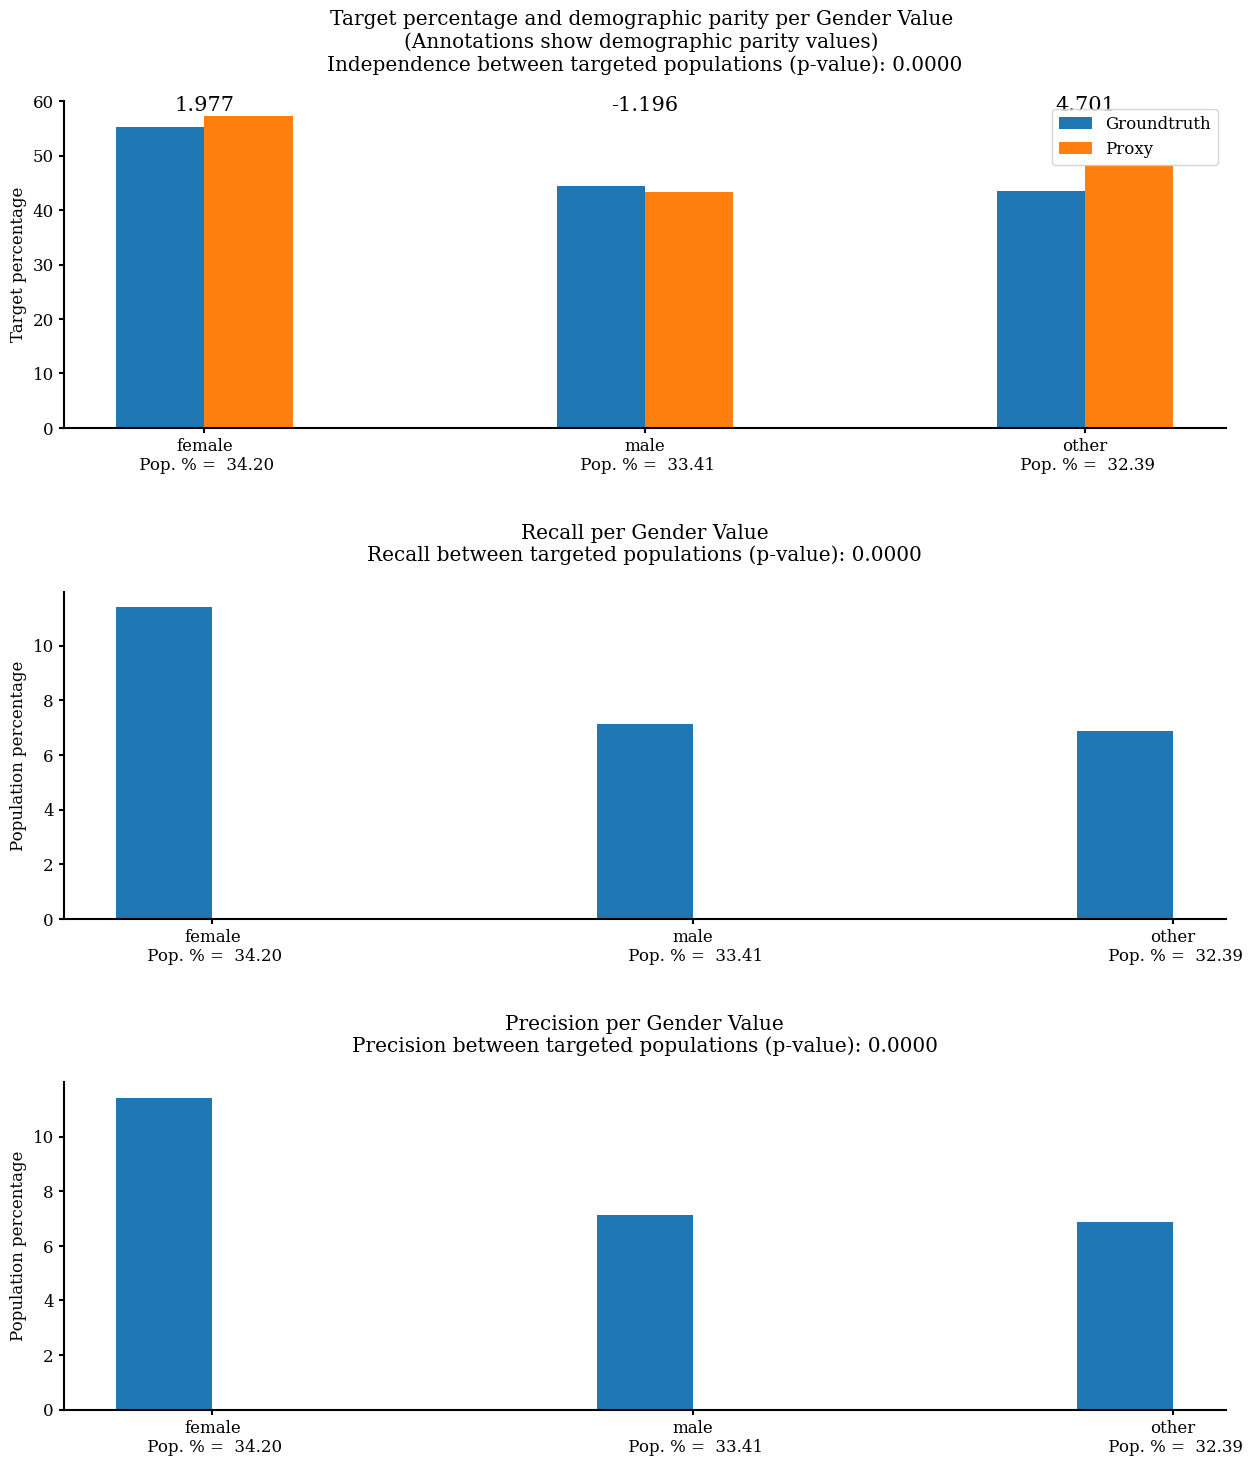

In [ ]:
# Compute all other fairness metrics per characteristic value
combined_results, statistics = combine_tables_on_characteristic(
    consumption_data_w_gender,
    50
)

fig, ax = plot_all_fairness_metrics_per_characteristic_value(combined_results, statistics, "Gender", color="blue")
fig